## 0 Librairies importation and management

In [1]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from xgboost.sklearn import XGBClassifier

import time

from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

data_train = pd.read_csv('./ML Data/train_validate.csv', index_col='trip_id')
data_predictions = pd.read_csv('./ML Data/test.csv', index_col='trip_id')

In [2]:
data_train.head()

household_id  person_id  trip_number choice  travel_dow trip_purpose  \
trip_id                                                                         
1                   1          1            1  drive           7   HOME_OTHER   
2                   1          1            2  drive           7        OTHER   
3                   1          1            3  drive           7   HOME_OTHER   
4                   1          1            4  drive           7     SHOPPING   
5                   1          1            5  drive           7     SHOPPING   

         distance  departure_hour  departure_min  hh_vehicles  hh_size  \
trip_id                                                                  
1        23.42579             9.0           20.0            2        2   
2         1.71259            12.0            5.0            2        2   
3        21.77887            15.0           30.0            2        2   
4         2.02603            17.0           30.0            2        2   
5         0.87691            18.0           15.0            2        2   

         hh_bikes  hh_descr  hh_income  gender  age  license  education_level  \
trip_id                                                                         
1               0         2          6       1   66      1.0                6   
2               0         2          6       1   66      1.0                6   
3               0         2          6       1   66      1.0                6   
4               0         2          6       1   66      1.0                6   
5               0         2          6       1   66      1.0                6   

        work_status  
trip_id              
1               FTE  
2               FTE  
3               FTE  
4               FTE  
5               FTE

# 1 Data pre-processing

## 1.1 Categorical data encoding

In [5]:
### Same categories for train and test set (for the categorical columns)
set(data_train['trip_purpose'].value_counts()) == set(data_predictions['trip_purpose'].value_counts())
set(data_train['work_status'].value_counts()) == set(data_predictions['work_status'].value_counts())

### Assess the low cardinality of the categorical variables (for efficient one-hot encoding)
display(data_train['trip_purpose'].value_counts())
display(data_train['work_status'].value_counts())
display(data_train['house_descr'].value_counts())

### Missing (nan) values in the dfs?
display(data_train.isnull().sum())
display(data_predictions.isnull().sum())

HOME_OTHER         18937
SHOPPING           13373
ESCORT_TRANSFER     9184
HOME_WORK           8060
OTHER               6680
HOME_EDU            3749
BUSINESS            1554
Name: trip_purpose, dtype: int64

FTE           26943
Student       11204
Retired        8039
PTE            6187
Volunteer      2900
Homemaker      2458
Unemployed     1927
Unknown        1879
Name: work_status, dtype: int64

household_id       0
person_id          0
trip_number        0
choice             0
travel_dow         0
trip_purpose       0
distance           0
departure_hour     0
departure_min      0
hh_vehicles        0
hh_size            0
hh_bikes           0
hh_descr           0
hh_income          0
gender             0
age                0
license            0
education_level    0
work_status        0
dtype: int64

household_id       0
person_id          0
trip_number        0
travel_dow         0
trip_purpose       0
distance           0
departure_hour     0
departure_min      0
hh_vehicles        0
hh_size            0
hh_bikes           0
hh_descr           0
hh_income          0
gender             0
age                0
license            0
education_level    0
work_status        0
dtype: int64

In [6]:
data_train.dtypes

household_id         int64
person_id            int64
trip_number          int64
choice              object
travel_dow           int64
trip_purpose        object
distance           float64
departure_hour     float64
departure_min      float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status         object
dtype: object

In [ ]:
# columns chosen for categorical one-hot encoding
categorical_cols = ['travel_dow','hh_descr','trip_purpose','work_status', 'license', 'gender']

In [7]:
def preprocessing(df):
  # To one-hot encode these numerical columns we have to convert the values to string
  df['travel_dow'] = df['travel_dow'].apply(str)
  df['gender'] = df['gender'].apply(str)
  df['license'] = df['license'].apply(str)
  df['hh_descr'] = df['hh_descr'].apply(str)
  
  # Concatenate time departure
  # Increased granularity for the time data. Departure minutes alone does not mean much.
  df['departure_time'] = df['departure_hour'] + df['departure_min']/60
  df = df.drop(['departure_hour', 'departure_min'], axis=1)

  return df

data_train = preprocessing(data_train)
data_predictions = preprocessing(data_predictions)




## 1.2 Train-test segmentation

In [8]:
target = ['choice']
id_context = [#'household_id', removed to permit grouped-cross-validation
              'person_id',
              'trip_number'
             ]
features = [column for column in data_train.columns 
            if column not in (target + id_context)]

y = data_train[target]
X = data_train[features]

X_data_predictions = data_predictions[features]
X_data_predictions = X_data_predictions.drop('household_id', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = y_train.choice.values
y_test = y_test.choice.values

## 1.3 Feature engineering

Here I start to lay out the bases of the sklearn pipeline that will be used to automate and encapsulate the preprocessing, parameter tuning and even model choosing. 

Since this dataset did not require a lot of preprocessing, the pipeline is quite light. However since pipelines can seem a bit frightening to use, it was a good moment to try to use them.


### 1.3.1 Scaling of numerical columns
A minmax scaler is used since it is more suited for generic scaling (minimal outliers and we don't want to lose the distribution form)

In [10]:
to_scale_cols = ['distance', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'age', 'education_level', 'departure_time']

scaling_pipeline = Pipeline([
                             ('minMax', MinMaxScaler())
])

## 1.3.2 Time data concatenation

In [11]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype('category').apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

# Chosen categorical columns are encoded to dummy variables
categorical_pipeline = Pipeline([
                         ('labeler', StringIndexer()),
                         ('encoder', OneHotEncoder(handle_unknown='ignore')),
                         ])

## 1.4 Feature Union

In [12]:
preprocessor = ColumnTransformer([
    ('categorical_cols', categorical_pipeline, categorical_cols),
    ('scaled_cols', scaling_pipeline, to_scale_cols)
])

# 2 Models definition 

## 2.1 Pipeline setup

In [13]:
class ClfSwitcher(ClassifierMixin, BaseEstimator):

    def __init__(
        self, 
        estimator = SGDClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [14]:
params = [
    {
        'clf__estimator': [RandomForestClassifier(criterion=gini)],
        "clf__estimator__max_depth": sp_randint(2,15),
        "clf__estimator__max_features": sp_randint(2,15),
        "clf__estimator__min_samples_split": sp_randint(2, 5),
        "clf__estimator__min_samples_leaf": sp_randint(2, 5),
        "clf__estimator__n_estimators" : sp_randint(50,150)
    },
        {
        'clf__estimator': [XGBClassifier()],
    }
]

classifier_pipeline = Pipeline([
    ('features_preprocessed', preprocessor),
    ('clf', ClfSwitcher()),
])

# We group on household to prevent data-leakage during cross-validation
gkf = GroupKFold(n_splits= 5)

%%time
rscv = RandomizedSearchCV(estimator = classifier_pipeline,
                          param_distributions=params,
                          scoring = "neg_log_loss",
                          n_jobs = -1,
                          cv = gkf,
                          n_iter = 1,
                          verbose=3)

search = rscv.fit(X_train,y_train,groups = X_train['household_id'])

search.best_params_
search.cv_results_['mean_fit_time'][search.best_index_]
search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.6min finished


-0.6087797626763148

In [25]:
# The best model is retrieved from the pipeline
best_model = search.best_estimator_['clf'].estimator

In [31]:
# We refit on the whole train set
search.best_estimator_.fit(X_train, y_train)
preds = search.best_estimator_.predict(X_test)


Confusion matrix, without normalization:


array([[  11,   62,   13,   13,   24],
       [   0, 7150,   10,   11,   94],
       [   0,  921, 1610,   91,   73],
       [   0,  342,  116,  377,   31],
       [   0,  316,  107,   23,  913]], dtype=int64)

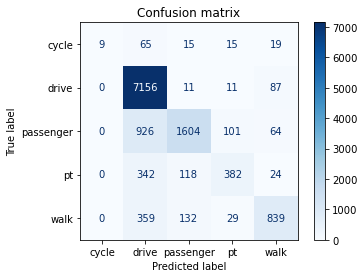

0.5067230880735267

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

print('Confusion matrix, without normalization:')
display(confusion_matrix(y_test, preds))

fig, ax = plt.subplots()
plot_confusion_matrix(best_model, preprocessor.fit_transform(X_test), y_test,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

display(log_loss(y_test, search.best_estimator_.predict_proba(X_test)))

In [ ]:
y_pred = logreg.predict(X_test)

# Accuracy
acc = metrics.accuracy_score(y_pred, y_test)
print("Accuracy: {:.2f}%".format(acc*100))

# Cross entropy loss
proba_validate = logreg.predict_proba(X_test)
logl = log_loss(y_test, proba_validate)
print("Log Loss = {:.4f}".format(logl))

Accuracy: 59.03%
Log Loss = 1.1316


Confusion matrix, without normalization:


array([[  48,   41,    8,   10,   16],
       [   0, 7140,   36,   10,   79],
       [   2,  508, 2061,   63,   61],
       [   0,  248,   87,  495,   36],
       [   2,  156,   74,   17, 1110]], dtype=int64)

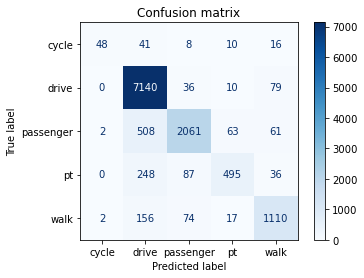

In [51]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

print('Confusion matrix, without normalization:')
display(confusion_matrix(y_test, preds))

fig, ax = plt.subplots()
plot_confusion_matrix(classifier_pipeline, X_test, y_test,values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [53]:
display(log_loss(y_test, classifier_pipeline.predict_proba(X_test)))

0.40487334361191457

In [ ]:
# refit on whole dataset
search.best_estimator_.fit(X, y)

# final predictions
y_pred_proba = search.best_estimator_.predict_proba(pd.DataFrame(X_data_predictions, columns=X_train.columns))
y_pred = search.best_estimator_.predict(pd.DataFrame(X_data_predictions, columns=X_train.columns))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


ValueError: ignored